In [2]:
import xarray as xr
import gcsfs
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
ds_faces = xr.open_zarr(gcsfs.GCSMap('pangeo-data/ECCO_chank.zarr'))

In [1]:
!pip install fsspec zarr git+https://github.com/xgcm/xmitgcm.git
!pip install fsspec zarr git+https://github.com/cspencerjones/xmitgcm@metric

  Cloning https://github.com/xgcm/xmitgcm.git to /tmp/pip-req-build-9hun2t0q
  Running command git clone -q https://github.com/xgcm/xmitgcm.git /tmp/pip-req-build-9hun2t0q
     |████████████████████████████████| 61kB 1.3MB/s 
  Stored in directory: /home/jovyan/.cache/pip/wheels/b0/8e/c6/99b47a23941843d18be0cbfd33c169c70864bc4de9821430e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-3lm66ufa/wheels/30/56/4a/2f821dca91af662f964a983b3855243a9de61945c506ee888e
Successfully built fsspec xmitgcm
  Cloning https://github.com/cspencerjones/xmitgcm (to revision metric) to /tmp/pip-req-build-xj6cpsx1
  Running command git clone -q https://github.com/cspencerjones/xmitgcm /tmp/pip-req-build-xj6cpsx1
  Running command git checkout -b metric --track origin/metric
  Switched to a new branch 'metric'
  Branch 'metric' set up to track remote branch 'metric' from 'origin'.
  Stored in directory: /tmp/pip-ephem-wheel-cache-vs1fhqdo/wheels/22/62/a2/2a606a4faba7cb0fa2ea3e034f256b73854ddba4eea1ef406d


In [4]:
#Apply Ryan's code to the dataset
ds_ll=faces_dataset_to_latlon(ds_faces, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO')])

#Exclude 1992 and put the Atlantic in the middle 
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False)).roll(i_g=180, roll_coords=False)

#Make a corresponding dataset of the coordinates of ds, with the same conditions as above(?)
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False)).roll(i_g=180, roll_coords=False)

In [9]:
def tryMask(newMask):
    #mask[ydimension, xdimnesion]
    newMask[215:, 0:147] = 0 #fixes top left pixel
    newMask[215:, 260:] = 0
    newMask[185:215, :120] = 0
    newMask[185:215, 260:] = 0 #right 
    newMask[185:199, 250:] = 0 #right
    newMask[:185, :133] = 0 #responsible for bottom left pixel
    newMask[:180, :141] = 0 #fixse bottom left pixeel 
    newMask[:185, 245:] = 0
    newMask[115:145, 135:155] = 0
    for j in coords.j[55:125]:
        for i in coords.i[205:245]:
            if j < (7/4)*i - 303.75:
                newMask[j,i] = 0
    return newMask

In [10]:
#Not masking the data with the mask, just isolating the box
vel = ds.LaVH3RHO[:, :, 220:259, 110:250]
delta_z = ds.LaHs3RHO[:, :, 220:259, 110:250]

In [11]:
#Taking some integrals
top = vel.sum('i')
bottom = delta_z.sum('i')
net = (top/bottom).sum('time')
net.load()

<xarray.DataArray (l3_c: 221, j_g: 39)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * j_g      (j_g) int64 220 221 222 223 224 225 226 ... 253 254 255 256 257 258
  * l3_c     (l3_c) int64 0 1 2 3 4 5 6 7 8 ... 213 214 215 216 217 218 219 220

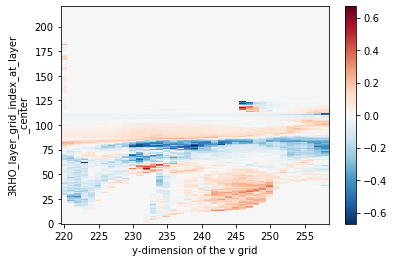

In [9]:
net.plot()

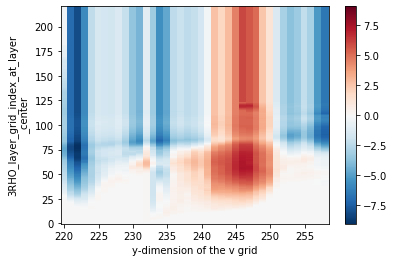

In [10]:
net.cumsum('l3_c').plot()

In [11]:
#Making a mask
mask = masknonAtlantic(coords.maskS.isel(k=0).load())

In [12]:
#Masking some data 
velocity = ds.LaVH3RHO * mask
depth = ds.LaHs3RHO * mask

In [13]:
#Top and bottom of the integral 
top = velocity.sum('i').mean('time')
bottom = depth.sum('i').mean('time')
net = (top / bottom)

In [14]:
net

<xarray.DataArray (l3_c: 221, j_g: 270)>
dask.array<shape=(221, 270), dtype=float64, chunksize=(221, 1)>
Coordinates:
  * l3_c     (l3_c) int64 0 1 2 3 4 5 6 7 8 ... 213 214 215 216 217 218 219 220
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
    k        int64 0

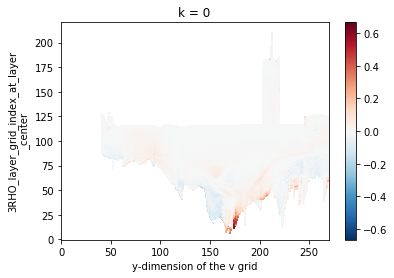

In [15]:
#Plot
net.plot() 